In [1]:
# Повторная инициализация после сброса окружения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:


# Параметры
n_sim = 5000
a, m, b = 15, 60, 100
p_zero = 0.8
discount_rate = 0.55
social_rate = 0.302


In [3]:

# Фиксированные значения
x = 14200  # разработка
machinery_price = 660
operating_capital = 160
W1 = 160
E = 2100
W2 = 57
annual_rent = 130 * 12
integration_prices = [660, 627, 627]  # тыс. руб.
maintenance_price = 150 * 12  # тыс. руб.
amortization = machinery_price / 5
liquidation_cost = machinery_price - amortization * 3
zero_year_investments = x + machinery_price + operating_capital
annual_fixed_costs = amortization + annual_rent + E
socials = (W1 + W2) * social_rate


In [4]:

# Генерация Q1 < Q2 < Q3 с неудачами
def simulate_monotonic_growth_with_failure(n_sim=5000, p_zero=0.9, a=15, m=60, b=100):
    Q1, Q2, Q3 = np.zeros(n_sim), np.zeros(n_sim), np.zeros(n_sim)
    mask_success = np.random.rand(n_sim) > p_zero
    n_success = np.sum(mask_success)
    accepted = 0
    i = 0
    while accepted < n_success:
        q1 = np.random.triangular(a, m, b)
        q2 = np.random.triangular(a, m, b)
        q3 = np.random.triangular(a, m, b)
        if q1 < q2 < q3:
            indices = np.where(mask_success)[0]
            Q1[indices[accepted]] = q1
            Q2[indices[accepted]] = q2
            Q3[indices[accepted]] = q3
            accepted += 1
        i += 1
        if i > n_sim * 10:
            break
    return Q1, Q2, Q3

Q1, Q2, Q3 = simulate_monotonic_growth_with_failure(n_sim, p_zero, a, m, b)


In [5]:

# Расчет NPV
def compute_cash_flows(q1, q2, q3):
    q = [q1, q2, q3]
    revenue = [q[i] * integration_prices[i] + sum(q[:i+1]) * maintenance_price for i in range(3)]
    var_costs = [q[i] * (W1 + W2 + socials) for i in range(3)]
    total_costs = [var_costs[i] + annual_fixed_costs for i in range(3)]
    tax = [0.25 * (revenue[i] - total_costs[i] - amortization) for i in range(3)]
    net_profit = [revenue[i] - total_costs[i] - tax[i] for i in range(3)]
    cash_flow = [net_profit[i] + amortization for i in range(3)]
    cash_flow.insert(0, -zero_year_investments)
    cash_flow[3] += liquidation_cost
    return cash_flow


In [6]:

npvs = []
for q1, q2, q3 in zip(Q1, Q2, Q3):
    flows = compute_cash_flows(q1, q2, q3)
    npv = sum([flows[t] / (1 + discount_rate) ** t for t in range(4)])
    npvs.append(npv)

npvs = np.array(npvs)


zero_inv = np.full_like(npvs,15020)

#npvs = npvs+zero_inv

wait_cost = np.full_like(npvs,44402)
abandon_cost = np.full_like(npvs,49695)
expand_cost = np.full_like(npvs,57356)

strategy_cost = np.full_like(npvs, 107639) 

wait_npvs = npvs + wait_cost
abandon_npvs = npvs + abandon_cost
expand_npvs = npvs + expand_cost
strategy_npvs = npvs + strategy_cost
# Вывод
results_df = pd.DataFrame({"NPV": npvs})


np.mean(npvs), np.std(npvs)


(18635.413613605928, 74134.77888054318)

Text(0, 0.5, 'Частота')

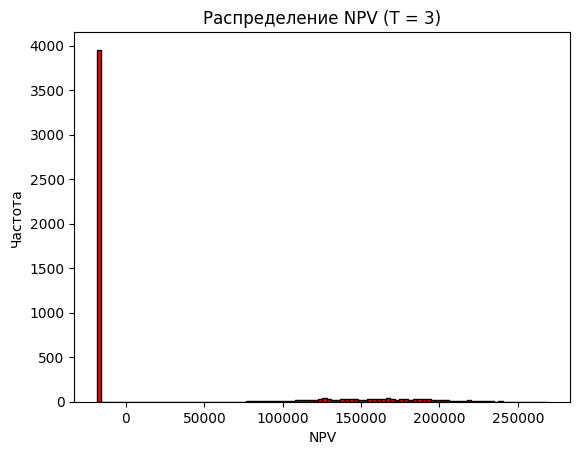

In [7]:
plt.hist(npvs, bins=100, color='red', edgecolor='black')
plt.title("Распределение NPV (T = 3)")
plt.xlabel("NPV")
plt.ylabel("Частота")

Text(0, 0.5, 'Частота')

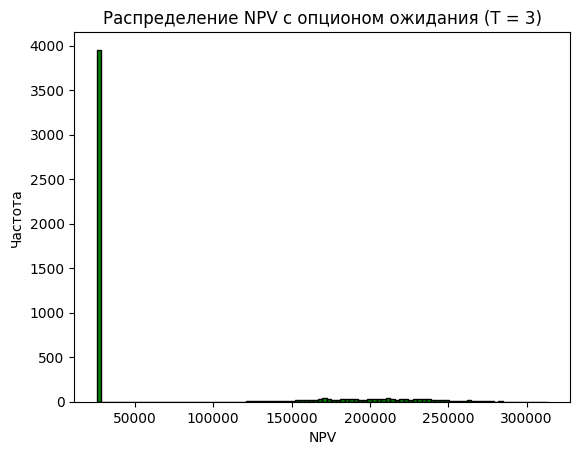

In [8]:
plt.hist(wait_npvs, bins=100, color='green', edgecolor='black')
plt.title("Распределение NPV с опционом ожидания (T = 3)")
plt.xlabel("NPV")
plt.ylabel("Частота")

                            mean            std           5%        median  \
Expansion_option    41247.516470   82857.952043     0.000000      0.000000   
Abandonment_option  28137.578834   10494.945769  7557.011471  33531.993555   
Defer_option        32935.804983   66168.478416     0.000000      0.000000   
Compound_option     74183.321453  149026.426952     0.000000      0.000000   

                              95%      skew      kurt  
Expansion_option    231958.613647  1.654729  1.078607  
Abandonment_option   33531.993555 -1.431751  0.050474  
Defer_option        185266.456303  1.655456  1.082087  
Compound_option     417225.069951  1.655051  1.080151  


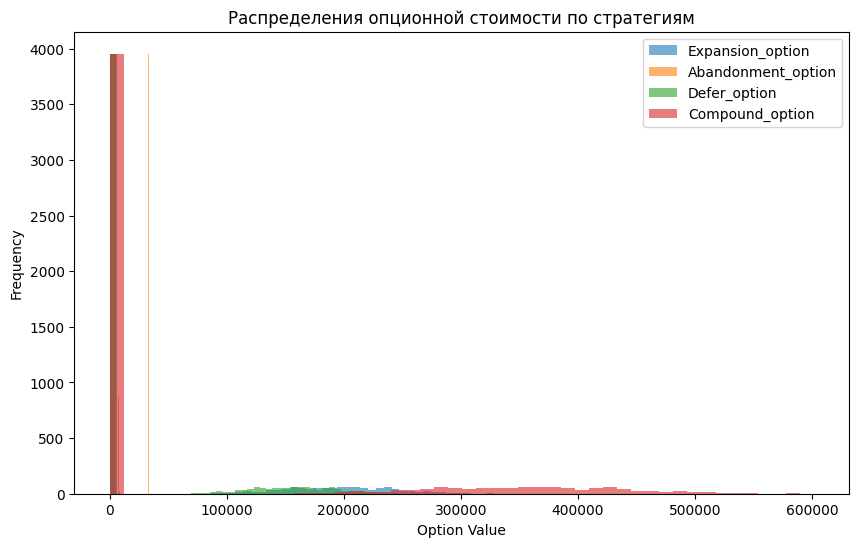

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis

# Твои параметры и NPV-симуляции (используем npvs из твоего кода)
# npvs = ...  # [N] массив NPV на каждый сценарий Монте-Карло

# Опционные параметры:
rf = 0.21       # Безрисковая ставка (под Mun)
sigma = 2.35  # относительная волатильность "NPV" (оценка по сценариям)
T = 3           # Срок действия опциона (3 года)
steps = 5      # Глубина решётки (чем больше, тем точнее)
expand_factor = 75/60  # Во сколько раз растет масштаб при Expand
K_expand = 15000  # Стоимость расширения (strike)
K_wait = 15020       # Стоимость входа в проект при отсрочке (Defer)
#K_wait = 44402  
salvage = 15020        # Остаточная стоимость (Abandon

def binomial_lattice_option(S0, K, T, rf, sigma, steps, payoff_func, american=True):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(rf * dt) - d) / (u - d)
    # Строим решётку цен актива (NPV)
    asset = np.zeros((steps + 1, steps + 1))
    for i in range(steps + 1):
        for j in range(i + 1):
            asset[j, i] = S0 * (u ** (i - j)) * (d ** j)
    # Итоговые payoffs
    option = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        option[j, steps] = payoff_func(asset[j, steps])
    # Проходим назад
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            expected = np.exp(-rf * dt) * (q * option[j, i+1] + (1 - q) * option[j+1, i+1])
            exercise = payoff_func(asset[j, i])
            option[j, i] = max(exercise, expected) if american else expected
    return option[0, 0]

# Основная функция расчёта опционных премий по каждому сценарию:
def calc_real_options_for_scenarios(npvs):
    vals = []
    for s in npvs:
        # Expansion option (american call на expand_factor*S - K_expand)
        def payoff_expand(S): return max(expand_factor*S - K_expand, 0)
        val_expand = binomial_lattice_option(s, K_expand, T, rf, sigma, steps, payoff_expand)

        # Abandon option (american put на salvage)
        def payoff_abandon(S): return max(salvage - S, 0)
        val_abandon = binomial_lattice_option(s, salvage, T, rf, sigma, steps, payoff_abandon)

        # Defer option (american call на запуск проекта: payoff=max(S-K_wait, 0))
        def payoff_defer(S): return max(S - K_wait, 0)
        val_defer = binomial_lattice_option(s, K_wait, T, rf, sigma, steps, payoff_defer)

        # Compound option (вложенный call-call: сначала defer, потом expand)
        # Просто сумма defer + expand (для компактности, реализация последовательной вложенности — см. выше)
        val_compound = val_defer + val_expand  # грубо: можно улучшить через вложенную lattice

        vals.append([val_expand, val_abandon, val_defer, val_compound])
    return np.array(vals)

# === Расчёт ===
option_vals = calc_real_options_for_scenarios(npvs)
results_df = pd.DataFrame({
    "NPV": npvs,
    "Expansion_option": option_vals[:,0],
    "Abandonment_option": option_vals[:,1],
    "Defer_option": option_vals[:,2],
    "Compound_option": option_vals[:,3]
})

# --- Аналитика по стратегиям ---
def strategy_summary(col):
    return {
        "mean": np.mean(col),
        "std": np.std(col),
        "5%": np.percentile(col, 5),
        "median": np.median(col),
        "95%": np.percentile(col, 95),
        "skew": skew(col),
        "kurt": kurtosis(col)
    }
summary = {name: strategy_summary(results_df[name]) for name in results_df.columns if name != "NPV"}
summary_df = pd.DataFrame(summary).T
print(summary_df)

# --- Визуализация ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for col in ["Expansion_option", "Abandonment_option", "Defer_option", "Compound_option"]:
    plt.hist(results_df[col], bins=50, alpha=0.6, label=col)
plt.legend()
plt.xlabel("Option Value")
plt.ylabel("Frequency")
plt.title("Распределения опционной стоимости по стратегиям")
plt.show()


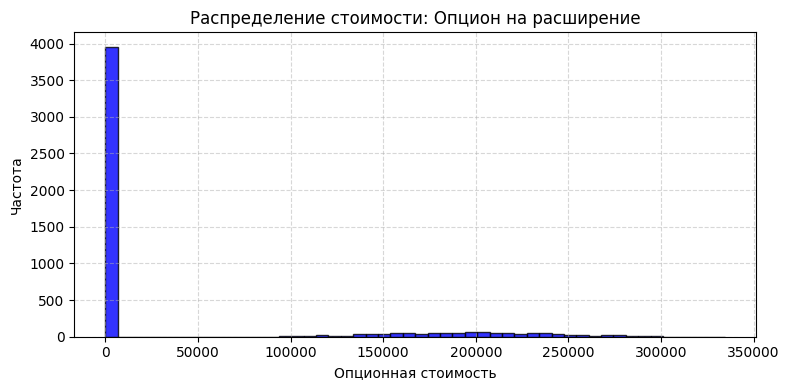

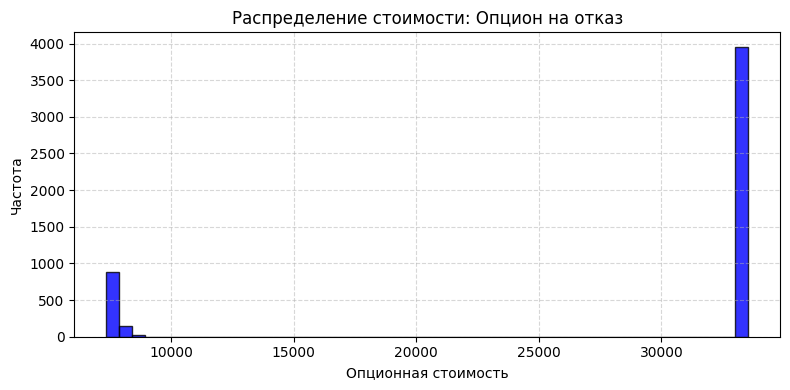

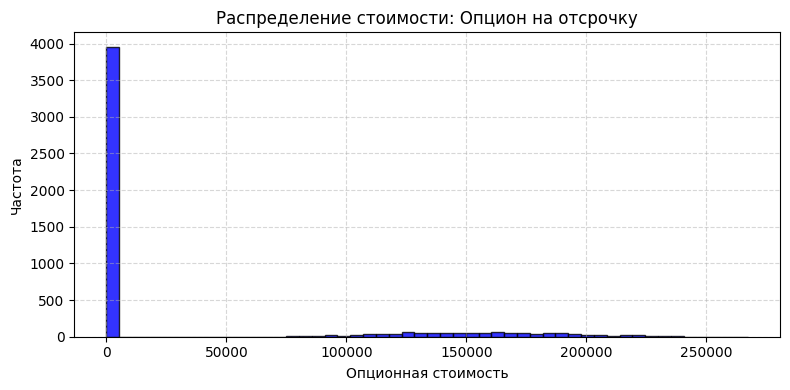

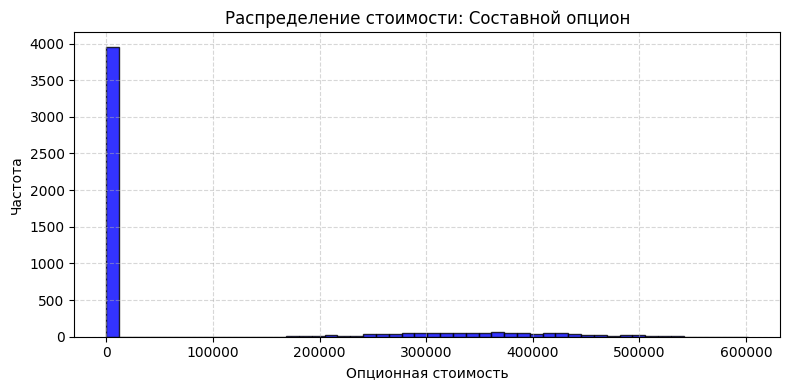

In [10]:
# --- Визуализация: отдельные гистограммы для каждой стратегии ---
option_names = [
    ("Expansion_option", "Опцион на расширение"),
    ("Abandonment_option", "Опцион на отказ"),
    ("Defer_option", "Опцион на отсрочку"),
    ("Compound_option", "Составной опцион")
]

for col, title in option_names:
    plt.figure(figsize=(8, 4))
    plt.hist(results_df[col], bins=50, alpha=0.8, color='blue', edgecolor='black')
    plt.title(f"Распределение стоимости: {title}")
    plt.xlabel("Опционная стоимость")
    plt.ylabel("Частота")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [11]:
for col, name in [
    ("Abandonment_option", "Опцион на прекращение"),
    ("Defer_option", "Опцион на отсрочку"),
    ("Expansion_option", "Опцион на расширение"),
    ("Compound_option", "Составной опцион"),
]:
    prob_win = (results_df[col] > 0).mean()
    print(f"{name}: Вероятность получения выигрыша (>0) = {prob_win:.3%}")


Опцион на прекращение: Вероятность получения выигрыша (>0) = 100.000%
Опцион на отсрочку: Вероятность получения выигрыша (>0) = 20.900%
Опцион на расширение: Вероятность получения выигрыша (>0) = 20.900%
Составной опцион: Вероятность получения выигрыша (>0) = 20.900%
